In [1]:
import datetime
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import itertools
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, RidgeCV, HuberRegressor, TheilSenRegressor, RANSACRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.utils import check_array
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection

In [2]:
train = pd.read_csv("data/train.csv", index_col="ID")
test = pd.read_csv("data/test.csv", index_col="ID")

In [3]:
for c in train.columns:
    if train[c].dtype == "object":
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

In [4]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train.drop(["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    train['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train['grp_' + str(i)] = grp_results_train[:, i - 1]
    test['grp_' + str(i)] = grp_results_test[:, i - 1]

    train['srp_' + str(i)] = srp_results_train[:, i - 1]
    test['srp_' + str(i)] = srp_results_test[:, i - 1]

/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [5]:
x_train = train.drop("y", axis=1)
x_test = test

In [6]:
# http://scikit-learn.org/stable/modules/feature_selection.html
sel = VarianceThreshold(threshold=(.95 * (1 - .95)))
sel.fit(x_train)

VarianceThreshold(threshold=0.04750000000000004)

In [7]:
x_train_reduced = pd.DataFrame(sel.transform(x_train))
x_test_reduced = pd.DataFrame(sel.transform(x_test))

In [8]:
x_train_reduced.shape, x_test_reduced.shape

((4209, 180), (4209, 180))

In [9]:
y_train = train["y"].values
y_mean = np.mean(y_train)

### Stacking different models

#### First Level

In [10]:
lasso_model = LassoLarsCV(normalize=True)
lasso_model.fit(x_train, y_train)
stack_1_train = lasso_model.predict(x_train)
stack_1_test = lasso_model.predict(x_test)

/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.235e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 5.373e-08
  ConvergenceWarning)
/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=7.235e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/datitran/anaconda/envs/kaggle/lib/python3.5/site-packages/sklearn/linear_model/least_ang

In [11]:
elastic_model = ElasticNetCV(normalize=True)
elastic_model.fit(x_train, y_train)
stack_2_train = elastic_model.predict(x_train)
stack_2_test = elastic_model.predict(x_test)

In [12]:
ridge_model = RidgeCV(normalize=True)
ridge_model.fit(x_train, y_train)
stack_3_train = ridge_model.predict(x_train)
stack_3_test = ridge_model.predict(x_test)

In [13]:
stack_4_train = []
stack_4_test = []
epsilon_values = [1.35, 1.5, 1.75, 1.9]
for i in epsilon_values:
    hubert_model = HuberRegressor(fit_intercept=True, epsilon=i)
    hubert_model.fit(x_train, y_train)
    stack_4_train.append(hubert_model.predict(x_train))
    stack_4_test.append(hubert_model.predict(x_test))

In [ ]:
"""
theilsen_model = TheilSenRegressor()
theilsen_model.fit(x_train, y_train)
stack_5 = theilsen_model.predict(x_train)
"""

In [ ]:
"""
ransac_model = RANSACRegressor()
ransac_model.fit(x_train, y_train)
stack_6 = ransac_model.predict(x_train)
"""

In [ ]:
"""
stack_7 = []
for depth, sample in itertools.product(range(3, 10), np.arange(0.7, 0.96, 0.05)):
    GBoost = GradientBoostingRegressor(learning_rate=0.001, loss="huber", 
                                       max_depth=depth, max_features=0.55, 
                                       min_samples_leaf=18, 
                                       min_samples_split=14, 
                                       subsample=sample)
    GBoost.fit(x_train, y_train)
    stack_7.append(GBoost.predict(x_train))
"""

In [14]:
stack_8_train = []
stack_8_test = []
for i in range(100, 250, 50):
    RForest = RandomForestRegressor(n_estimators=i,
                                    oob_score=True,
                                    n_jobs=-1,
                                    max_features="auto",
                                    min_samples_leaf=50)
    RForest.fit(x_train, y_train)
    stack_8_train.append(RForest.predict(x_train))
    stack_8_test.append(RForest.predict(x_test))

In [24]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

stack_9_train = []
stack_9_test = []
for i in range(3, 7):
    xgb_params = XGBRegressor(
            n_estimators=500,
            learning_rate=0.005,
            max_depth=i,
            subsample=0.95,
            objective="reg:linear",
            base_score=y_mean)
    model = xgb.train(dict(xgb_params.get_params(), silent=0), dtrain, num_boost_round=1250)
    stack_9_train.append(model.predict(dtrain))
    stack_9_test.append(model.predict(dtest))

In [25]:
# Combine all results together and build data set for level 2
stack_level_1_train = pd.DataFrame.transpose(pd.DataFrame(np.vstack([stack_1_train, stack_2_train, stack_3_train, stack_4_train, stack_8_train, stack_9_train])))
stack_level_1_test = pd.DataFrame.transpose(pd.DataFrame(np.vstack([stack_1_test, stack_2_test, stack_3_test, stack_4_test, stack_8_test, stack_9_test])))

In [26]:
# score
r2_values = []
for i in range(0, len(stack_level_1_train.columns)):
    r2_values.append((i, r2_score(y_train, stack_level_1_train[i])))

In [30]:
dict(r2_values)

{0: 0.53061478066924761,
 1: 0.56929049438691648,
 2: 0.58685807024820325,
 3: 0.51828346069086551,
 4: 0.51726212117809078,
 5: 0.52723157083879135,
 6: 0.52121826001626625,
 7: 0.60881125173098982,
 8: 0.60880462343584441,
 9: 0.60834109239002654,
 10: 0.63940396647727216,
 11: 0.68419438716967507,
 12: 0.73032257315507454,
 13: 0.77558879739114084}

In [31]:
r2_score(y_train, stack_level_1_train.mean(axis=1))

0.62533672450434064

#### Second Level

In [32]:
dtrain = xgb.DMatrix(stack_level_1_train, y_train)
dtest = xgb.DMatrix(stack_level_1_test)

In [33]:
xgb_params = XGBRegressor(n_estimators=500,
                    learning_rate=0.005,
                    max_depth=3,
                    subsample=0.95,
                    objective="reg:linear",
                    base_score=y_mean)

In [35]:
cv_output = xgb.cv(xgb_params.get_params(), dtrain, num_boost_round=4000, early_stopping_rounds=50, 
                   verbose_eval=50, show_stdv=False)

[0]	train-rmse:12.6272	test-rmse:12.6251
[50]	train-rmse:10.4894	test-rmse:10.5087
[100]	train-rmse:8.92	test-rmse:8.97204
[150]	train-rmse:7.77745	test-rmse:7.87875
[200]	train-rmse:6.92405	test-rmse:7.0855
[250]	train-rmse:6.29824	test-rmse:6.51521
[300]	train-rmse:5.84011	test-rmse:6.11156
[350]	train-rmse:5.50652	test-rmse:5.82665
[400]	train-rmse:5.26012	test-rmse:5.62296
[450]	train-rmse:5.07452	test-rmse:5.4761
[500]	train-rmse:4.92905	test-rmse:5.36708
[550]	train-rmse:4.81329	test-rmse:5.28614
[600]	train-rmse:4.71981	test-rmse:5.22731
[650]	train-rmse:4.64269	test-rmse:5.17993
[700]	train-rmse:4.5828	test-rmse:5.14499
[750]	train-rmse:4.53102	test-rmse:5.11479
[800]	train-rmse:4.48825	test-rmse:5.08919
[850]	train-rmse:4.45133	test-rmse:5.06846
[900]	train-rmse:4.41788	test-rmse:5.04883
[950]	train-rmse:4.38899	test-rmse:5.03206
[1000]	train-rmse:4.36281	test-rmse:5.0188
[1050]	train-rmse:4.33659	test-rmse:5.00476
[1100]	train-rmse:4.31294	test-rmse:4.9922
[1150]	train-rmse:4

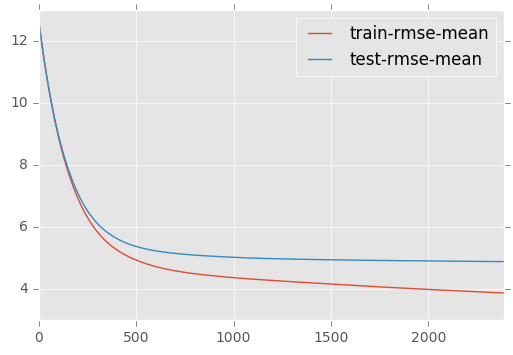

In [36]:
cv_output[["train-rmse-mean", "test-rmse-mean"]].plot()
pass

In [37]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params.get_params(), silent=0), dtrain, num_boost_round=num_boost_rounds)

In [38]:
y_pred_train = model.predict(dtrain)

In [39]:
r2_score(y_train, y_pred_train)

0.89905151477985712

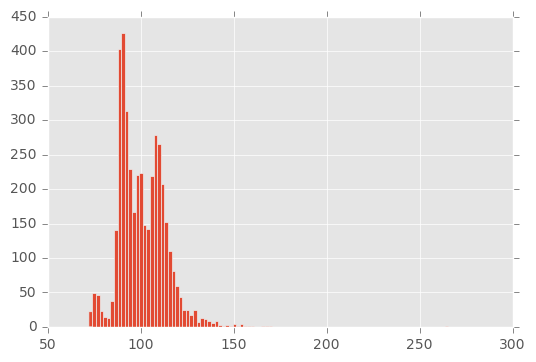

In [40]:
pd.Series(y_train).hist(bins=100)

### Prediction

In [41]:
y_predict = model.predict(dtest)

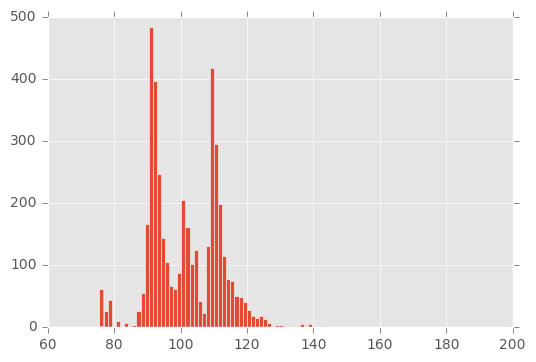

In [42]:
pd.Series(y_predict).hist(bins=100)

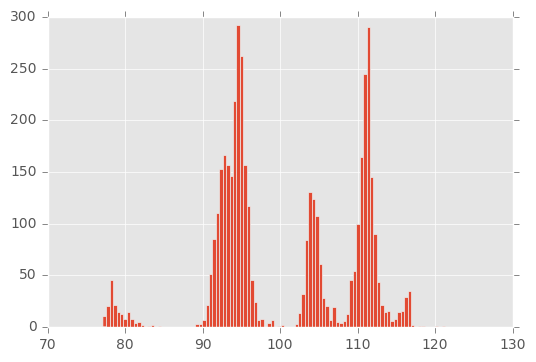

In [48]:
stack_level_1_test.mean(axis=1).hist(bins=100)

### Averaging

In [49]:
stacked_kaggle_model = pd.read_csv("Good_Submissions/stacked-models.csv")

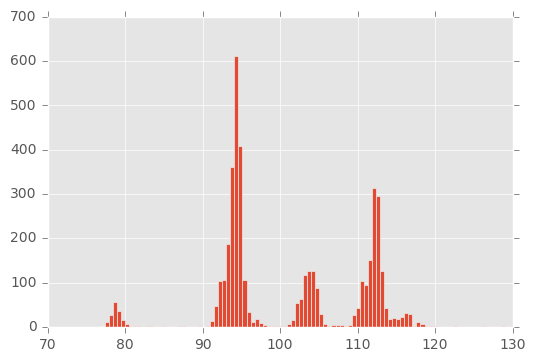

In [52]:
stacked_kaggle_model.y.hist(bins=100)

### Output

In [56]:
stacked_level_1_average = stack_level_1_test.mean(axis=1)

In [59]:
final_prediction = (stacked_kaggle_model.y + stacked_level_1_average) / 2

In [60]:
output = pd.DataFrame({"ID": test.index, "y": final_prediction})

In [61]:
output.to_csv("submissions_stacked_average.csv", index=False)